# PRISMO vs MEFISTO on Mouse brain Visium data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MEFISTO

In [2]:
# from mofapy2.run.entry_point import entry_point
# from data_loader import load_mefisto_visium

# adata = load_mefisto_visium()

# ent = entry_point()
# ent.set_data_options(use_float32=True)
# ent.set_data_from_anndata(adata)
# ent.set_model_options(factors=4)
# ent.set_train_options()
# ent.set_train_options(seed=54321)
# n_inducing = 1000

# ent.set_covariates([adata.obsm["spatial"]], covariates_names=["imagerow", "imagecol"])
# ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing / adata.n_obs, start_opt=10, opt_freq=10)
# ent.build()
# ent.run()

# expectations = ent.model.getExpectations()
# ent.save("models/mefisto.hdf5")

## PRISMO

In [25]:
from data_loader import load_mefisto_visium
from prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions

adata = load_mefisto_visium()

for seed in range(10):
    prismo_model = PRISMO(
        adata,
        DataOptions(
            covariates_obsm_key="spatial",
            plot_data_overview=False
        ),
        ModelOptions(
            n_factors=4,
            weight_prior="SnS",
            factor_prior="GP",
            likelihoods="Normal"
        ),
        TrainingOptions(
            device="cuda:0",
            early_stopper_patience=500,
            lr=5e-2,
            save_path=f"models/prismo_{seed}",
            seed=seed
        ),
        SmoothOptions(
            n_inducing=1000,
            kernel="RBF"
        )
    )

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/data/florin/prismo_project/prismo-analysis/comparison_mefisto_visium/data_loader.py:31: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
INFO:prismo._core.prismo:Setting up device...
INFO:prismo._core.prismo:- Using provided likelihood for all views.
INFO:prismo._core.prismo:  - view_1: Normal
INFO:prismo._core.prismo:Initializing factors using `random` met

## Comparison

In [27]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mefistox as mefisto
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_mefisto_visium
import os
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
mefisto_model = mofa.mofa_model("models/mefisto.hdf5")
z_mefisto = pd.DataFrame(
    mefisto_model.factors["group1"][:].T,
    index=mefisto_model.samples["group1"],
    columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)],
) / 10

w_mefisto = pd.DataFrame(
    mefisto_model.weights["rna"][:].T,
    index=mefisto_model.features["rna"],
    columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)]
) * 10

z_prismo = {}
w_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()["group_1"]
    w_prismo[seed] = prismo_model[seed].get_weights()["view_1"].T

### Factor matching based on correlation

In [102]:
for seed in range(10):
    z_mefisto_inds, z_prismo_inds, z_signs = match(z_mefisto, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    w_prismo[seed] = w_prismo[seed].iloc[:, z_prismo_inds]
    w_prismo[seed] = w_prismo[seed] * z_signs.reshape(1, -1)
    w_prismo[seed].columns = [f"Factor {i+1}" for i in range(w_prismo[seed].shape[1])]

w_prismo_mean = {}
for view in w_prismo[0].keys():
    w_prismo_mean = pd.concat([w_prismo[seed] for seed in range(10)], axis=0).groupby(level=0).mean()

z_prismo_mean = pd.concat([z_prismo[seed] for seed in range(10)], axis=0).groupby(level=0).mean()

### Correlation plots

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2.5 x 2 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/correlations.pdf
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows conta

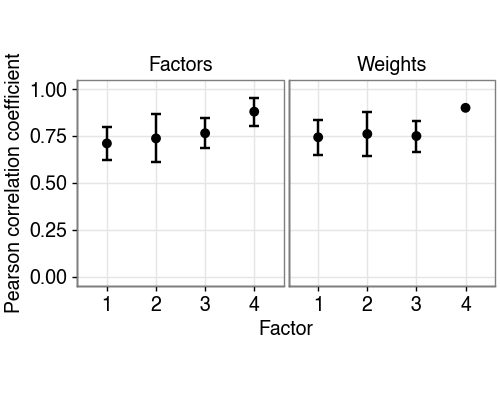

In [103]:
df = []
for seed in range(10):
    corr = []
    for i in range(z_prismo[seed].shape[1]):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_mefisto.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(z_prismo[seed].shape[1])]
    df[-1]["lv"] = "Factors"

    corr = []
    for i in range(w_prismo[seed].shape[1]):
        corr.append(pearsonr(w_prismo[seed].iloc[:, i], w_mefisto.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=[f"corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(w_prismo[seed].shape[1])]
    df[-1]["lv"] = f"Weights"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(10)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0, a_max=10)
df["max"] = np.clip(df["max"], a_min=0, a_max=10)

plot = (
    ggplot(df, aes(x="factor", y="mean"))
    + geom_point(size=1.)
    + geom_line()
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=5)
    + theme(
        figure_size=(2.5, 2),
    )
    + labs(x="Factor", y="Pearson correlation coefficient")
    + ylim(0, 1)
)
plot.save("plots/correlations.pdf")
plot.show()

### Weights scatter plots

In [108]:
def plot_weights(factor, w_prismo_mean, w_mefisto):
    df = pd.DataFrame(w_prismo_mean[factor])
    df.columns = ["weight_prismo"]
    df["weight_mefisto"] = w_mefisto[factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_mefisto_abs"] = df["weight_mefisto"].abs()

    plot = (
        ggplot(df, aes(x="weight_prismo", y="weight_mefisto"))
        + geom_point(size=.1)
        + labs(x="PRISMO weight", y="MEFISTO weight", title=f"{factor}")
        + theme(figure_size=(1.5, 1.5))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor1_weights.pdf


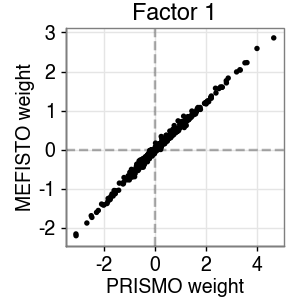

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor2_weights.pdf


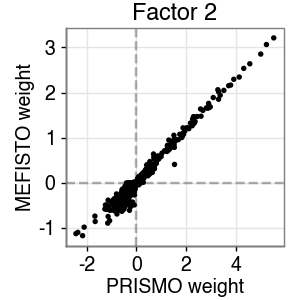

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor3_weights.pdf


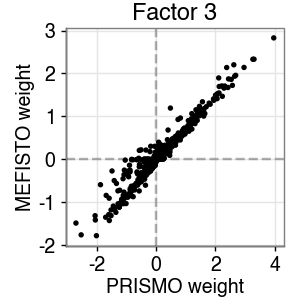

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor4_weights.pdf


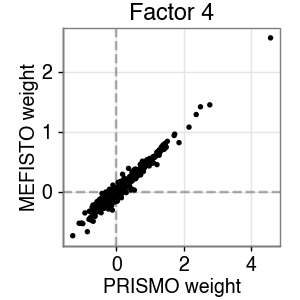

In [109]:
for i in range(1, 5):
    plot = plot_weights(f"Factor {i}", w_prismo_mean, w_mefisto)
    plot.save(f"plots/factor{i}_weights.pdf")
    plot.show()

### Factor scatter plots

In [110]:
def plot_factors(factor, z_prismo_mean, z_mefisto):
    df = pd.DataFrame(z_prismo_mean.loc[:, factor])
    df.columns = ["factor_prismo"]
    df["factor_mefisto"] = z_mefisto.loc[:, factor]
    df["factor_prismo_abs"] = df["factor_prismo"].abs()
    df["factor_mefisto_abs"] = df["factor_mefisto"].abs()

    plot = (
        ggplot(df, aes(x="factor_prismo", y="factor_mefisto"))
        + geom_point(size=.1)
        + labs(x="PRISMO factor", y="MEFISTO factor", title=f"{factor}")
        + theme(figure_size=(1.5, 1.5))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor1_factors.pdf


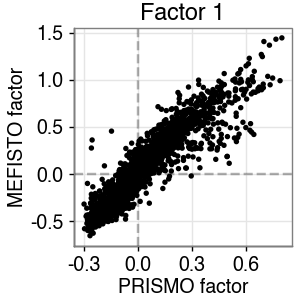

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor2_factors.pdf


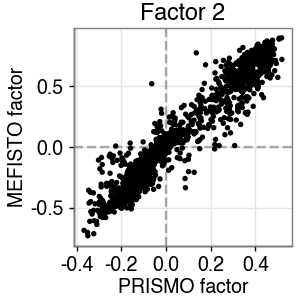

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor3_factors.pdf


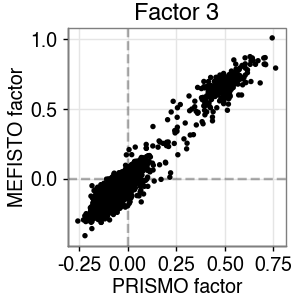

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/factor4_factors.pdf


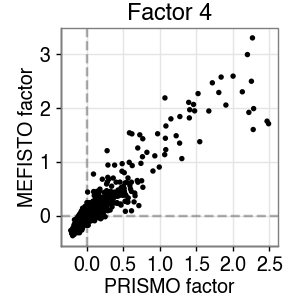

In [111]:
for i in range(1, 5):
    plot = plot_factors(f"Factor {i}", z_prismo_mean, z_mefisto)
    plot.save(f"plots/factor{i}_factors.pdf")
    plot.show()

## Plots

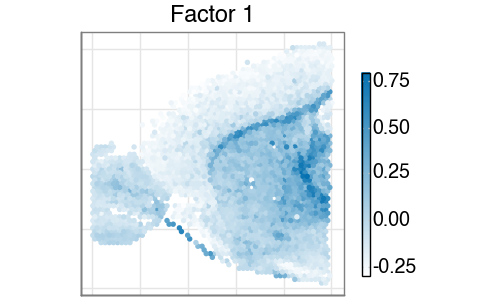

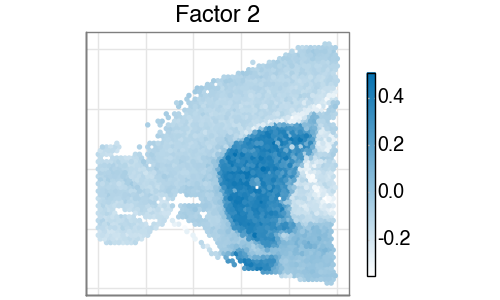

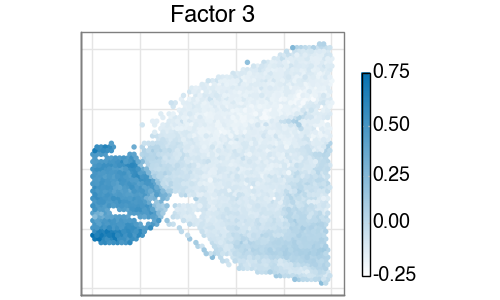

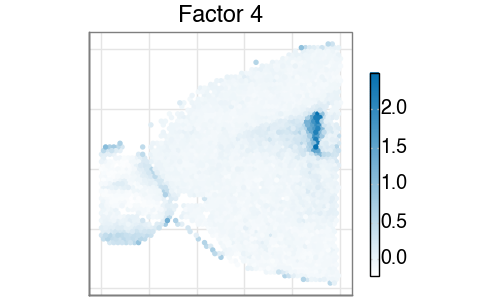

In [112]:
covariates_df = pd.DataFrame(prismo_model[0].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_prismo_mean, columns=[f"Factor {i+1}" for i in range(z_prismo_mean.shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#0571b0")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/prismo_factor_{factor}.pdf")
    plot.show()

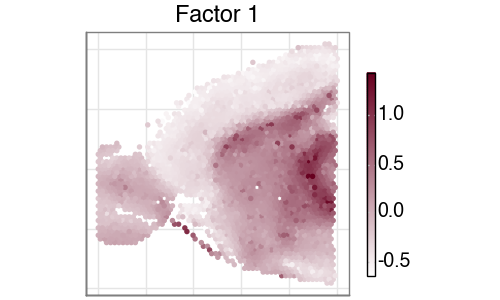

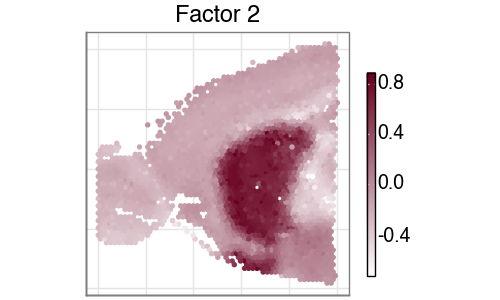

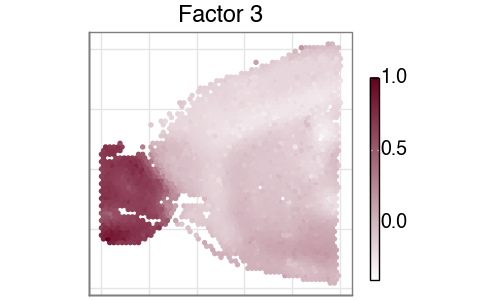

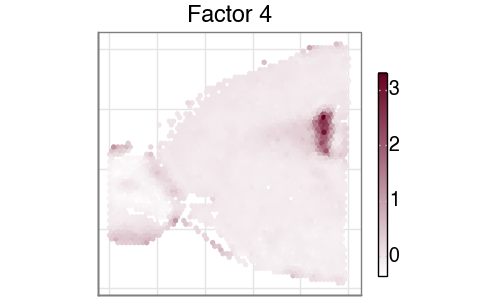

In [113]:
covariates_df = pd.DataFrame(prismo_model[0].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_mefisto, columns=[f"Factor {i+1}" for i in range(z_prismo_mean.shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]

for factor in range(1, 5):
    plot = (ggplot(df, aes(x="x", y="y", color=f"Factor {factor}"))
        + geom_point(size=0.1)
        + theme(figure_size=(2.5, 1.5), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major_x=element_blank(), axis_ticks_major_y=element_blank(), legend_key_width=3.)
        + labs(x="", y="", color="", title=f"Factor {factor}")
        + coord_fixed(ratio=1)
        + scale_color_gradient(low="white", high="#67001f")
    )

    fig = plot.draw()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    fig.savefig(f"plots/mefisto_factor_{factor}.pdf")
    plot.show()